In this notebook, we will be performing customer segmentation.

# List of Contents:

- Import libraries
- Loading Data
- Data Cleaning
- Data Preprocessing
- Dimensionality Reduction
- Clustering

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

import warnings
warnings.simplefilter("ignore")

## Loading Data

In [2]:
df = pd.read_csv('marketing_campaign.csv', sep='\t')
print(f'There are {len(df)} observations within our data.')
df.head()

There are 2240 observations within our data.


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


## Data Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

All the values are non-null except some values in <code>Income</code>. Dropping these would be better. The <code>Dt_Customer</code> seems to have date data but it is an object type. We should change that.

In [4]:
df.dropna(inplace=True)
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

In [5]:
df['Marital_Status'].value_counts()

Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

We can create new features:
- <code>Spendings</code> from all the products.
- <code>Children</code> from <code>Kidhome</code> and <code>Teenhome</code>.
- <code>Age</code> from <code>Year_Birth</code>.
- <code>Has_partner</code> from <code>Marital_Status</code>.

In [6]:
df = df.rename(columns={
    'MntWines':'Wines',
    'MntFruits':'Fruits', 
    'MntMeatProducts':'MeatProducts', 
    'MntFishProducts':'FishProducts', 
    'MntSweetProducts':'SweetProducts', 
    'MntGoldProds':'GoldProds'
})

df['Spendings'] = df['Wines'] + df['Fruits'] + df['MeatProducts'] + df['FishProducts'] + df['SweetProducts'] + df['SweetProducts'] + df['GoldProds']

df['Children'] = df['Kidhome'] + df['Teenhome']

df['Age'] = 2023 - df['Year_Birth']

df['Has_partner'] = df['Marital_Status'].map({
    'Married':'Yes',
    'Together':'Yes',
    'Divorced':'No',
    'Single':'No',
    'Widow':'No', 
    'Alone':'No', 
    'Absurd':'No', 
    'YOLO':'No'
})

<code>Dt_Customer</code> tells when the customer data was entered in our database. Information from this variable could form another variable, <code>Shopping_since</code>. This variable can tell how long someone has been a customer to our services.

In [7]:
max_date = df['Dt_Customer'].max() 

df['Shopping_since'] = df['Dt_Customer'].apply(lambda x: (max_date - x).days)
df['Shopping_since'] = df['Shopping_since'].astype(int)

In [8]:
df['Education'].value_counts()

Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64

<code>Education</code> can be grouped into 3 classes.

In [9]:
df['Education'] = df['Education'].map({
    'Basic':'Undergrad',
    '2n Cycle':'Undergrad',
    'Graduation':'Graduate',
    'Master':'Postgrad',
    'PhD':'Postgrad'
})

In [10]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'Wines', 'Fruits', 'MeatProducts',
       'FishProducts', 'SweetProducts', 'GoldProds', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact',
       'Z_Revenue', 'Response', 'Spendings', 'Children', 'Age', 'Has_partner',
       'Shopping_since'],
      dtype='object')

A new variable can be created; <code>Is_a_Parent</code> from <code>Children</code> and then the <code>Family_mbs</code> could be created to find the size of the family from <code>Children</code> and <code>Has_partner</code>.

In [11]:
df['Is_a_Parent'] = df['Children'].apply(lambda x: 1 if x > 0 else 0)

df['Family_mbs'] = df['Has_partner'].map({'Yes':2,'No':1}) + df['Children']

Extra features that are not deemed necessary can be dropped.

In [12]:
feat2drop = ['ID', 'Year_Birth', 'Marital_Status', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue']
df.drop(feat2drop, axis=1, inplace=True)

In [13]:
df.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,MeatProducts,FishProducts,SweetProducts,GoldProds,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Spendings,Children,Age,Shopping_since,Is_a_Parent,Family_mbs
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,634.104242,0.947202,54.179603,512.006318,0.714350,2.592509
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,628.681514,0.749062,11.985554,232.469034,0.451825,0.905722
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,27.000000,0.000000,0.000000,1.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,73.000000,0.000000,46.000000,340.000000,0.000000,2.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,405.000000,1.000000,53.000000,513.000000,1.000000,3.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,1099.000000,1.000000,64.000000,686.000000,1.000000,3.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,2672.000000,3.000000,130.000000,1063.000000,1.000000,5.000000


The max age is 130 years. We need to fix that. Let's take a look at other variables that might need to be fixed.

In [14]:
# sns.pairplot(df.sample(1000), hue='Family_mbs', palette=['yellow', 'green'])

<code>Income</code> has outlier value that needs to be taken care of.

In [15]:
df = df[(df['Age']<95)]
df = df[(df['Income']<600_000)]

## Data Preprocessing

In [16]:
object_columns = df.select_dtypes(include=['object'])
print(object_columns)

     Education Has_partner
0     Graduate          No
1     Graduate          No
2     Graduate         Yes
3     Graduate         Yes
4     Postgrad         Yes
...        ...         ...
2235  Graduate         Yes
2236  Postgrad         Yes
2237  Graduate          No
2238  Postgrad         Yes
2239  Postgrad         Yes

[2212 rows x 2 columns]


In [17]:
l_encoder=LabelEncoder()
for i in object_columns:
    df[i]=df[[i]].apply(l_encoder.fit_transform)

Preprocess data for PCA.

In [18]:
df_components_analysis = df.copy()

There would be some unnecessary features that need to be removed for the decomposition.

In [19]:
feat2drop = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
df_components_analysis.drop(feat2drop, axis=1, inplace=True)

Now, we scale the features.

In [20]:
scaler = StandardScaler()
scaler.fit(df_components_analysis)
scaled_df = pd.DataFrame(scaler.transform(df_components_analysis),columns=df_components_analysis.columns)

In [21]:
scaled_df.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,MeatProducts,FishProducts,SweetProducts,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Spendings,Children,Age,Has_partner,Shopping_since,Is_a_Parent,Family_mbs
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.704508,-1.264598,1.018352,-1.349603,1.973583,-1.581139,-1.758359
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-0.965240,1.404572,1.274785,-1.349603,-1.665144,0.632456,0.449070
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,0.258992,-1.264598,0.334530,0.740959,-0.172664,-1.581139,-0.654644
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-0.920665,0.069987,-1.289547,0.740959,-1.923210,0.632456,0.449070
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.295017,0.069987,-1.033114,0.740959,-0.822130,0.632456,0.449070


## Dimensionality Reduction

In [22]:
pca = PCA(n_components=3)
pca.fit(scaled_df)
PCA_df = pd.DataFrame(pca.transform(scaled_df), columns=(['PC1','PC2', 'PC3']))
PCA_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PC1,2212.0,3.854662e-17,2.880645,-5.968090,-2.538090,-0.781461,2.389776,7.473446
PC2,2212.0,-5.139550e-17,1.706101,-4.313212,-1.329813,-0.157902,1.244699,6.125933
PC3,2212.0,1.927331e-17,1.221834,-3.527483,-0.821685,-0.026834,0.800655,6.616593


## Clustering

- Elbow Method to determine the number of clusters to be formed
- Clustering via Agglomerative Clustering
- Examining the clusters formed via scatter plot

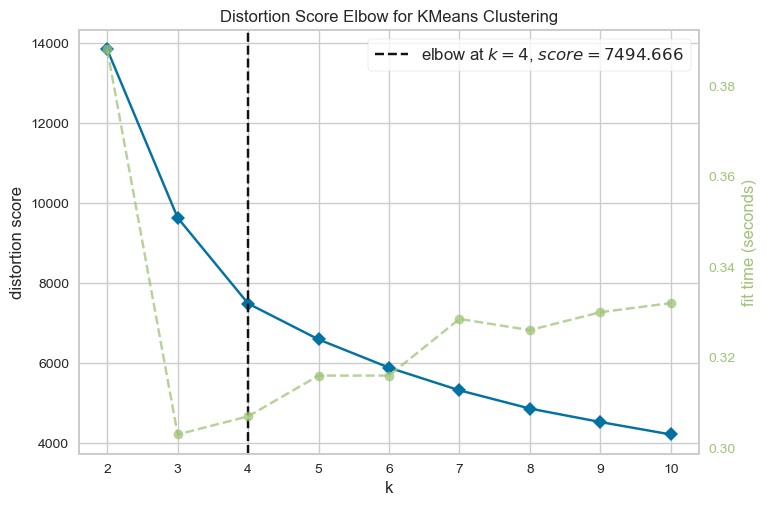

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
k_elbow = KElbowVisualizer(KMeans(), k=10)
k_elbow.fit(PCA_df)
k_elbow.show()

We will use 4 clusters for Agglomerative Clustering.

In [24]:
agglo_cluster = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
y_pred = agglo_cluster.fit_predict(PCA_df)
PCA_df['Clusters'] = y_pred
#Adding the Clusters feature to the orignal dataframe.
df['Clusters']= y_pred

## Evaluation and Profiling

Distribution of clustering

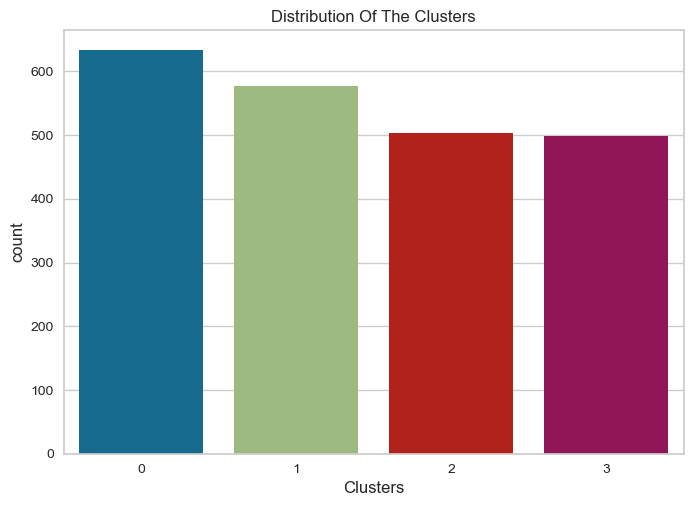

In [26]:
sns.countplot(x=df['Clusters'])
plt.title('Distribution Of The Clusters')
plt.show()

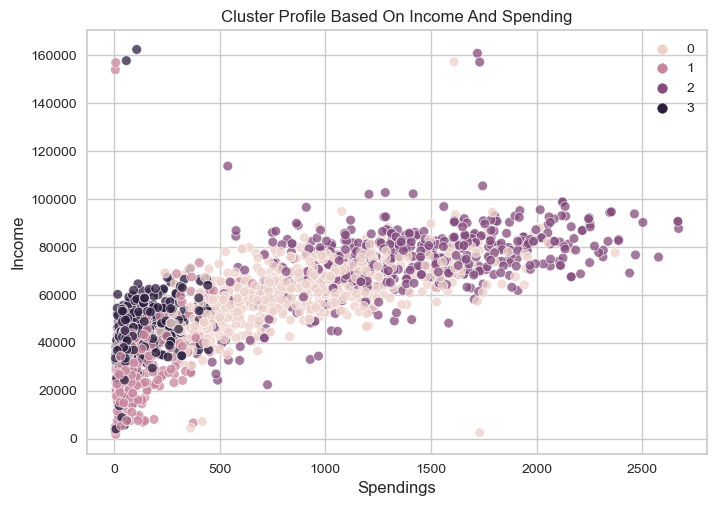

In [27]:
sns.scatterplot(data = df,x=df['Spendings'], y=df['Income'],hue=df['Clusters'], alpha=0.75)
plt.title('Cluster Profile Based On Income And Spending')
plt.legend()
plt.show()

Income vs spending plot shows the clusters pattern

- Group 0: High spending & Average income
- Group 1: Low spending & Low income 
- Group 2: High spending & High income
- Group 3: Low spending & High income

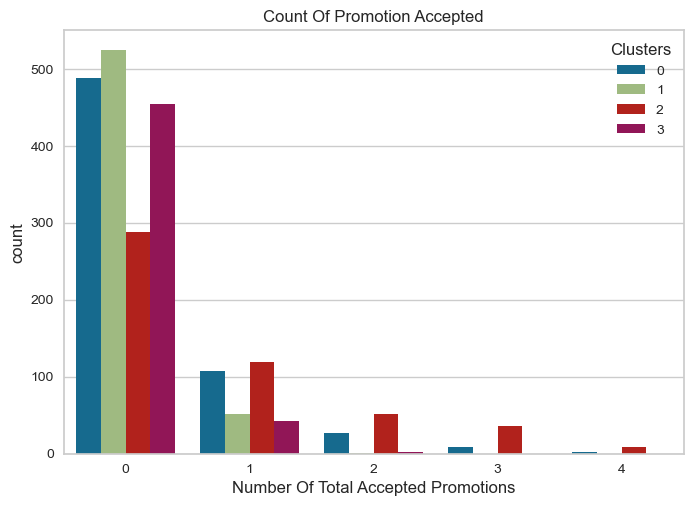

In [28]:
df['Total_Promos'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3']+ df['AcceptedCmp4']+ df['AcceptedCmp5']
#Plotting count of total campaign accepted.
plt.figure()
sns.countplot(x=df['Total_Promos'],hue=df['Clusters'])
plt.title('Count Of Promotion Accepted')
plt.xlabel('Number Of Total Accepted Promotions')
plt.show()

All groups do not make use of all the promotions. Most do not accept any promotions. Now that we have formed the clusters and looked at their purchasing habits. 

In [29]:
df.columns

Index(['Education', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'Wines',
       'Fruits', 'MeatProducts', 'FishProducts', 'SweetProducts', 'GoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'Spendings', 'Children', 'Age', 'Has_partner',
       'Shopping_since', 'Is_a_Parent', 'Family_mbs', 'Clusters',
       'Total_Promos'],
      dtype='object')

<Figure size 800x550 with 0 Axes>

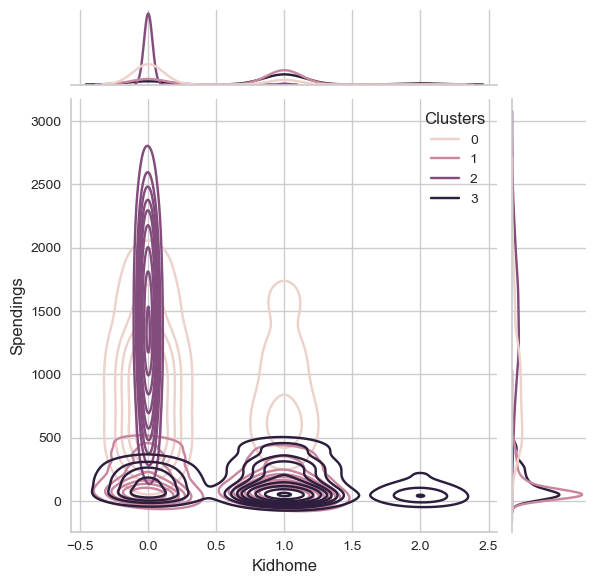

<Figure size 800x550 with 0 Axes>

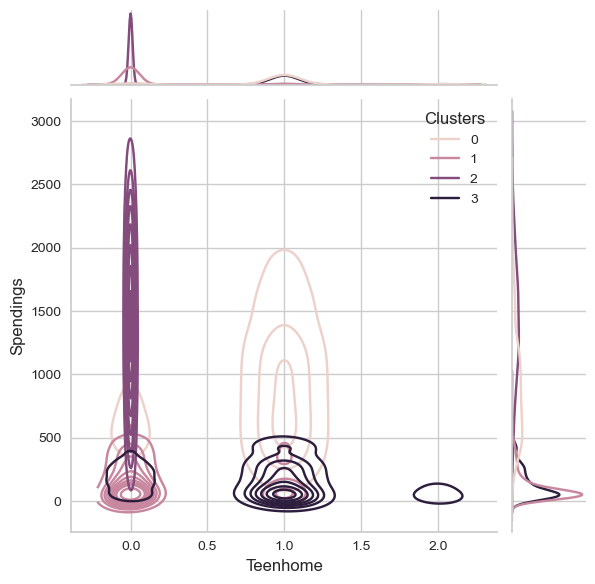

<Figure size 800x550 with 0 Axes>

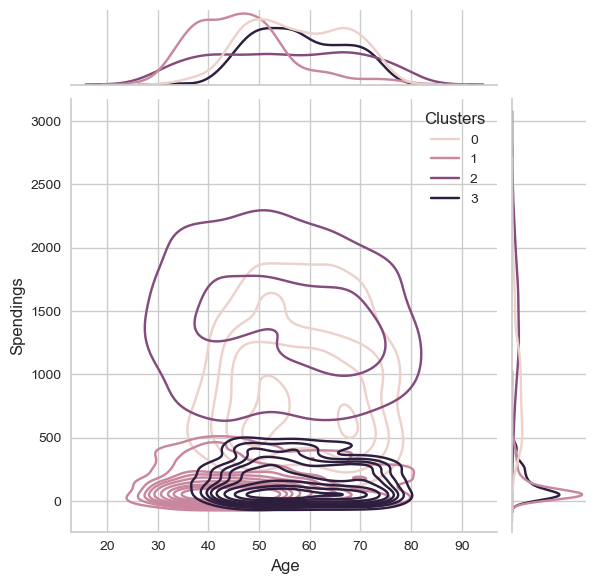

<Figure size 800x550 with 0 Axes>

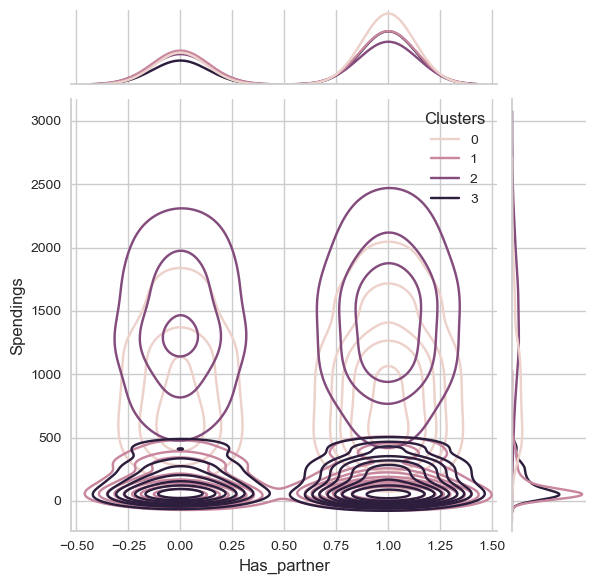

<Figure size 800x550 with 0 Axes>

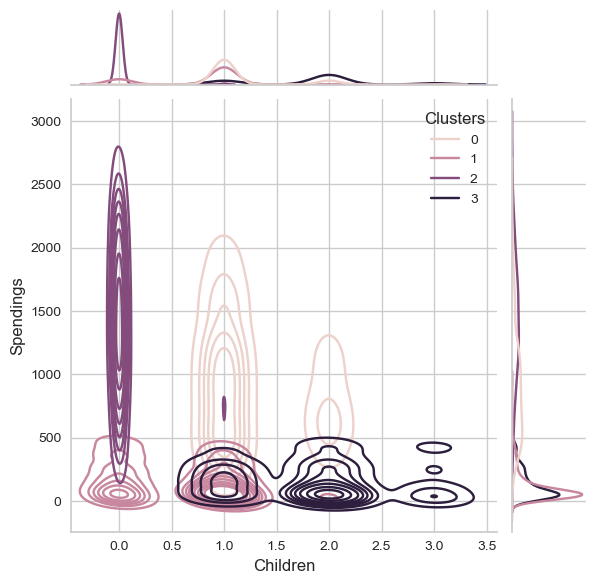

<Figure size 800x550 with 0 Axes>

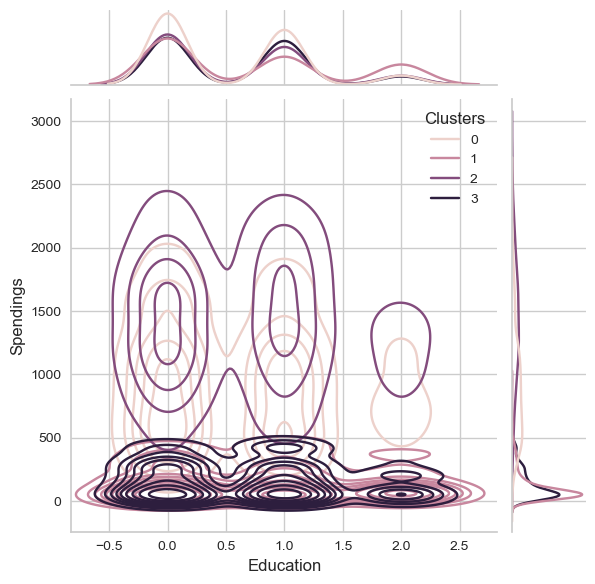

<Figure size 800x550 with 0 Axes>

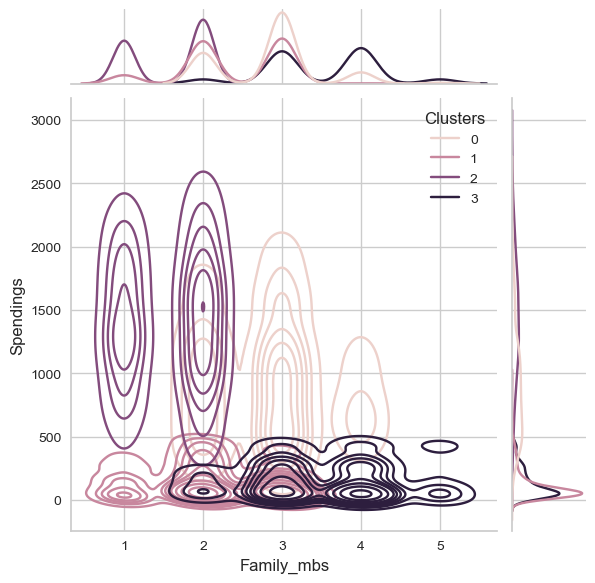

<Figure size 800x550 with 0 Axes>

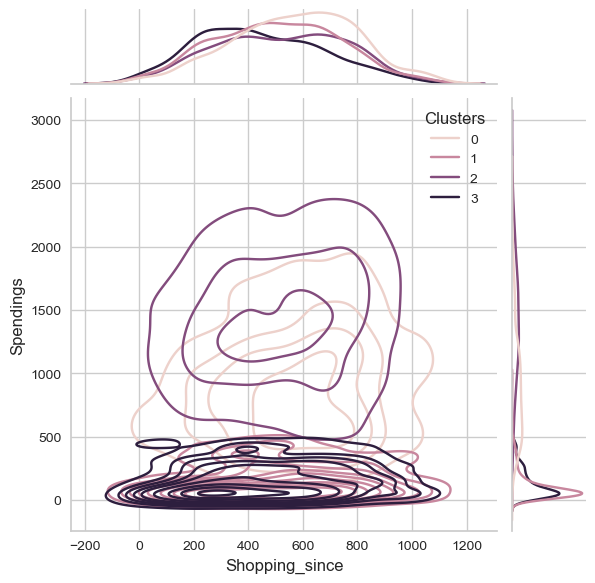

<Figure size 800x550 with 0 Axes>

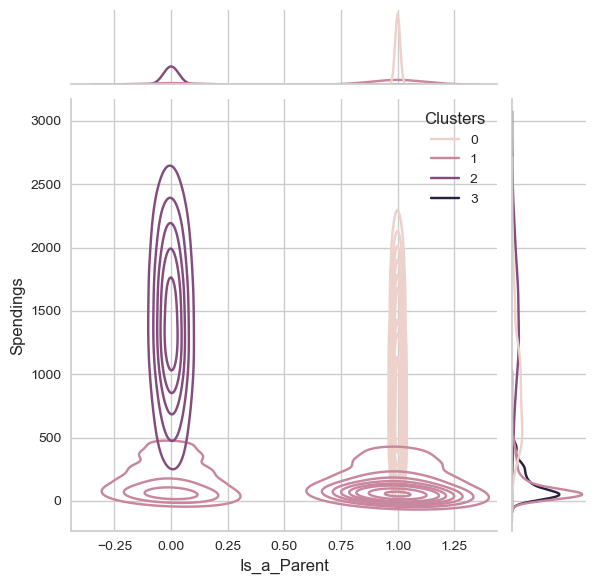

In [30]:
customer_info = ['Kidhome','Teenhome', 'Age', 'Has_partner', 'Children', 'Education', 'Family_mbs','Shopping_since', 'Is_a_Parent']

for i in customer_info:
    plt.figure()
    sns.jointplot(x=df[i], y=df['Spendings'], hue=df['Clusters'], kind='kde')
    plt.show()

### Insights from all segments:

Cluster 0: 
- Have a family with 2-4 members.
- A lot of them have a teenager.
- The age of customers from this cluster is around 50 years.
- High spending & Average income group.

Cluster 1: 
- Relatively younger.
- Most do not have any children.
- Family members 1-3.
- Low spending & Low income group.

Cluster 2:
- Most have 1 child at max.
- Family members 1-2.
- Highest spenders of all the groups.
- High spending & High income group.

Cluster 3:
- Family has 3-5 members.
- Have 1-3 children with atleast one teenager.
- Spend the least.
- Low spending & High income group.

When it comes to promotions, it's fascinating to see how different groups of people respond. Not everyone embraces promotions with open arms; in fact, the majority of individuals tend to pass on them altogether. It's intriguing to delve into the reasons behind this behavior and explore the various factors that influence people's decisions. By understanding why some individuals are less inclined to accept promotions, businesses can fine-tune their marketing strategies and tailor their offers to better meet the needs and preferences of different customer segments. It's a captivating area of study that unravels the complexities of human behavior and sheds light on the diverse responses to promotional initiatives.